**GAN** (generate images and masks)

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from PIL import Image
import matplotlib.pyplot as plt

# Set device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

# Paths
image_path = '/content/drive/MyDrive/ISIC 2016/train'
mask_path = '/content/drive/MyDrive/ISIC 2016/train_masks'

# Transformations for images (RGB)
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for RGB images
])

# Transformations for masks (grayscale)
mask_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()  # No normalization for masks
])

# Dataset for images and masks
class ImageMaskDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB")  # Convert to RGB for color images
        mask = Image.open(mask_path).convert("L")  # Grayscale mask
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

# DataLoader
dataset = ImageMaskDataset(image_dir=image_path, mask_dir=mask_path, image_transform=image_transform, mask_transform=mask_transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

# Generator (RGB + Mask Output)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # Output RGB Image
            nn.Tanh()  # For RGB image output
        )

        self.mask_head = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),  # Output single-channel Mask (grayscale)
            nn.Sigmoid()  # Sigmoid to ensure mask values are between 0 and 1
        )

    def forward(self, input):
        image_output = self.main(input)
        mask_output = self.mask_head(input)
        return image_output, mask_output

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1, bias=False),  # Input: concatenated image + mask (RGB + mask)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models
latent_dim = 100
generator = Generator().to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
G_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Mask loss function
def mask_loss(pred_mask, real_mask):
    criterion = nn.BCELoss()  # Now we use BCE loss, as the mask is binary (0 or 1)
    return criterion(pred_mask, real_mask)

# Training loop
num_epochs = 40
os.makedirs('generated_images', exist_ok=True)
os.makedirs('generated_masks', exist_ok=True)

for epoch in range(1, num_epochs + 1):
    for real_images, real_masks in train_loader:
        real_images = real_images.to(device)
        real_masks = real_masks.to(device)
        real_targets = torch.ones(real_images.size(0), device=device)  # Shape: (batch_size,)
        fake_targets = torch.zeros(real_images.size(0), device=device)  # Shape: (batch_size,)

        # Train Discriminator
        D_optimizer.zero_grad()
        real_pairs = torch.cat((real_images, real_masks), dim=1)  # Concatenate image and mask
        D_real_loss = adversarial_loss(discriminator(real_pairs), real_targets)
        noise = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        fake_images, fake_masks = generator(noise)
        fake_pairs = torch.cat((fake_images, fake_masks), dim=1)  # Concatenate fake image and mask
        D_fake_loss = adversarial_loss(discriminator(fake_pairs.detach()), fake_targets)
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()

        # Train Generator
        G_optimizer.zero_grad()
        G_image_loss = adversarial_loss(discriminator(fake_pairs), real_targets)
        G_mask_loss = mask_loss(fake_masks, real_masks)  # Mask loss
        G_loss = G_image_loss + G_mask_loss  # Combined loss
        G_loss.backward()
        G_optimizer.step()

    print(f"Epoch {epoch}/{num_epochs}, D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

    # Save generated images and masks every 10 epochs
    if epoch % 10 == 0:
        save_image(fake_images, f'generated_images/epoch_{epoch}.png', normalize=True)
        save_image(fake_masks, f'generated_masks/epoch_{epoch}.png', normalize=True)


Epoch 1/40, D Loss: 0.1146, G Loss: 16.0685
Epoch 2/40, D Loss: 0.4084, G Loss: 7.8172
Epoch 3/40, D Loss: 0.2067, G Loss: 9.1529
Epoch 4/40, D Loss: 0.0289, G Loss: 7.5212
Epoch 5/40, D Loss: 0.4674, G Loss: 3.0814
Epoch 6/40, D Loss: 0.3186, G Loss: 4.3345
Epoch 7/40, D Loss: 1.5991, G Loss: 3.1890
Epoch 8/40, D Loss: 0.8465, G Loss: 3.9390
Epoch 9/40, D Loss: 0.8777, G Loss: 4.4164
Epoch 10/40, D Loss: 0.2115, G Loss: 5.1372
Epoch 11/40, D Loss: 2.0658, G Loss: 5.0272
Epoch 12/40, D Loss: 0.4307, G Loss: 4.8088
Epoch 13/40, D Loss: 1.0016, G Loss: 6.6518
Epoch 14/40, D Loss: 0.6417, G Loss: 1.7849
Epoch 15/40, D Loss: 1.1557, G Loss: 1.9142
Epoch 16/40, D Loss: 1.0649, G Loss: 3.0672
Epoch 17/40, D Loss: 3.9274, G Loss: 1.4649
Epoch 18/40, D Loss: 2.2266, G Loss: 2.5363
Epoch 19/40, D Loss: 0.4208, G Loss: 4.8345
Epoch 20/40, D Loss: 0.8904, G Loss: 3.6093
Epoch 21/40, D Loss: 1.6417, G Loss: 3.5857
Epoch 22/40, D Loss: 0.4409, G Loss: 3.4341
Epoch 23/40, D Loss: 1.5023, G Loss: 2.6

**Generate and save 3000 images with GAN**


In [ ]:
import os
import torch
from torchvision.utils import save_image

def generate_and_save_images(generator, num_images=500, latent_dim=3000, device='cuda', save_dir='generated'):
    os.makedirs(save_dir, exist_ok=True)  # Create directory to save images if it doesn't exist

    generator.eval()  # Set to evaluation mode
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)  # Latent vector
    with torch.no_grad():  # No need to track gradients
        fake_images, fake_masks = generator(noise)  # Generate fake images and masks

    # Convert generated images and masks to the [0, 1] range
    fake_images = (fake_images + 1) / 2  # Tanh outputs [-1, 1], so we map them to [0, 1]
    fake_masks = (fake_masks + 1) / 2  # Same for masks if using Tanh

    # Save generated images and masks
    for i in range(num_images):
        # Save generated images
        save_image(fake_images[i], os.path.join(save_dir, f'fake_image_{i+1}.png'))

        # Save generated masks
        save_image(fake_masks[i], os.path.join(save_dir, f'fake_mask_{i+1}.png'), normalize=True)

    print(f"Saved {num_images} images and masks in '{save_dir}'")

# Example usage
generate_and_save_images(generator, num_images=3000, latent_dim=100, device='cuda', save_dir='generated')


Saved 3000 images and masks in 'generated'


**Evaluate the 3000 (GAN) generated images and masks with pre-trained U-Nen**

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


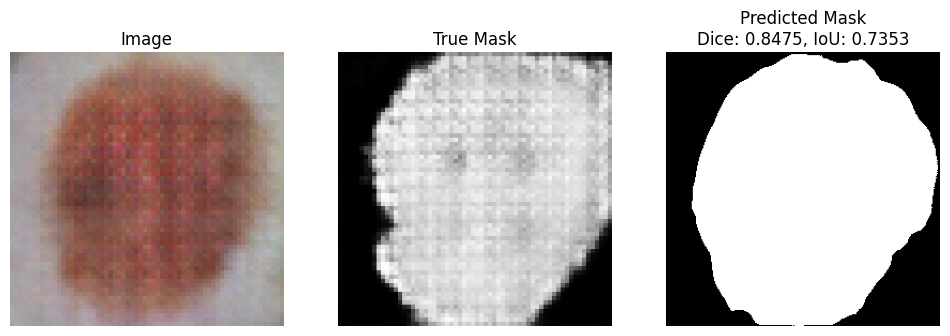

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


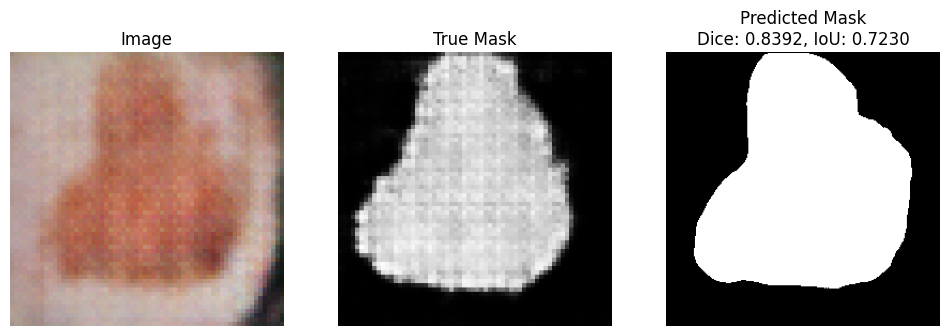

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


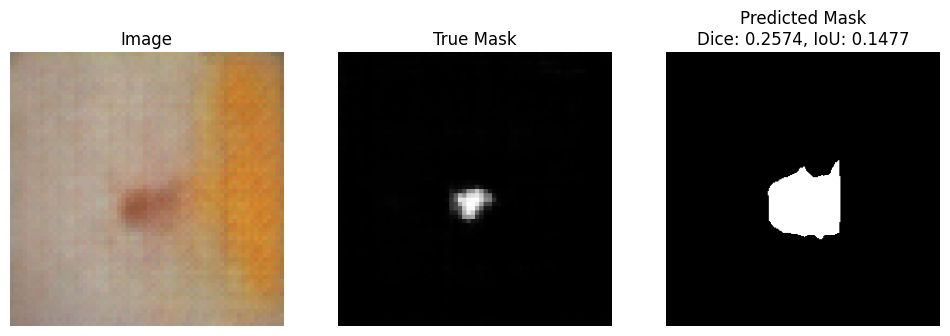

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


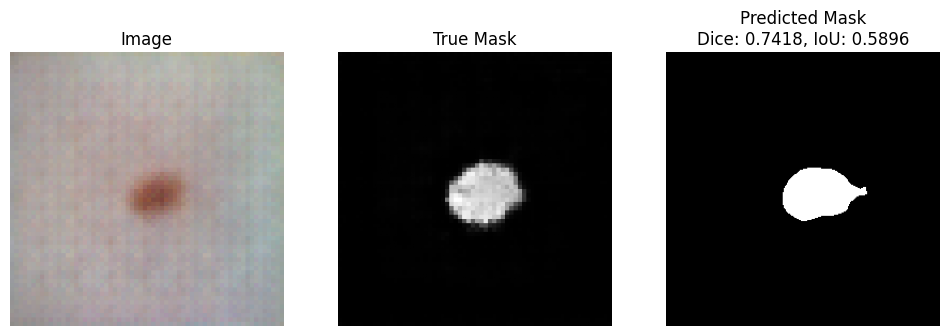

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


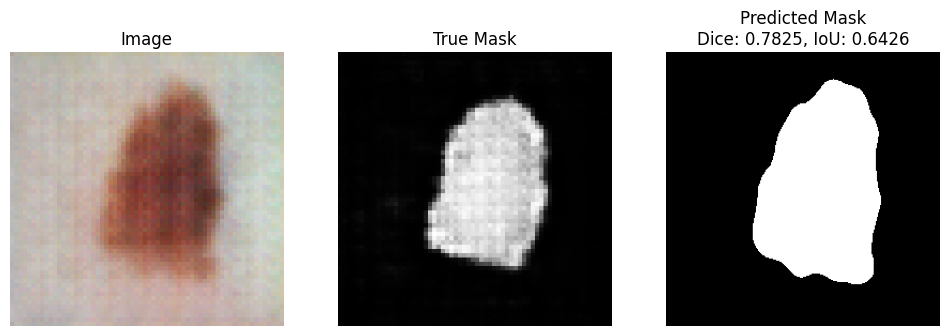

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf  # Ensure TensorFlow is imported


# Function to load and preprocess test images and masks
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and preprocess the image and mask
        image = img_to_array(load_img(img_path, target_size=target_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode="grayscale")) / 255.0

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Dice coefficient calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

# Intersection over Union (IoU) calculation
def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Display sample predictions
def display_sample_predictions(model, x_test, y_test, num_samples=5):
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    for i in indices:
        image = x_test[i]
        true_mask = y_test[i]
        pred_mask = model.predict(image[np.newaxis, ...])[0]

        # Threshold the prediction
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Calculate Dice and IoU
        dice_score = dice_coefficient(true_mask, pred_mask).numpy()
        iou_score = intersection_over_union(true_mask, pred_mask).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, 0], cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, 0], cmap="gray")
        plt.title(f"Predicted Mask\nDice: {dice_score:.4f}, IoU: {iou_score:.4f}")
        plt.axis("off")

        plt.show()

# Evaluate metrics on the test set
def evaluate_metrics_on_test_set(model, x_test, y_test):
    dice_scores = []
    iou_scores = []

    for i in range(len(x_test)):
        true_mask = y_test[i]
        pred_mask = model.predict(x_test[i][np.newaxis, ...])[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_scores.append(dice_coefficient(true_mask, pred_mask).numpy())
        iou_scores.append(intersection_over_union(true_mask, pred_mask).numpy())

    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/unet___model.h5"
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient})

# Directories for generated images and masks
image_dir = "/content/drive/MyDrive/generatedIGAN"
mask_dir = "/content/drive/MyDrive/generatedMGAN"

# Load the test images and masks
x_test, y_test = load_images_and_masks(image_dir, mask_dir)

# Display sample predictions
display_sample_predictions(model, x_test, y_test, num_samples=5)

# Evaluate and display metrics
evaluate_metrics_on_test_set(model, x_test, y_test)


**DFCA-GAN**

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from PIL import Image
import matplotlib.pyplot as plt

# Set device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

# Paths
image_path = '/content/drive/MyDrive/ISIC 2016/train'
mask_path = '/content/drive/MyDrive/ISIC 2016/train_masks'

# Transformations for images (RGB)
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for RGB images
])

# Transformations for masks (grayscale)
mask_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()  # No normalization for masks
])

# Dataset for images and masks
class ImageMaskDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB")  # Convert to RGB for color images
        mask = Image.open(mask_path).convert("L")  # Grayscale mask
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

# DataLoader
dataset = ImageMaskDataset(image_dir=image_path, mask_dir=mask_path, image_transform=image_transform, mask_transform=mask_transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

# Dynamic Feature Contextual Activation (DFCA) Module
class DFCA(nn.Module):
    def __init__(self, channels):
        super(DFCA, self).__init__()
        self.channels = channels
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // 2),
            nn.ReLU(True),
            nn.Linear(channels // 2, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, c, h, w = x.size()
        x_reshaped = x.view(batch_size, c, -1)  # Flatten spatial dimensions
        context = torch.mean(x_reshaped, dim=2)  # Calculate the global context (mean of spatial features)
        context = self.fc(context)  # Shape: (batch_size, c)
        context = context.view(batch_size, c, 1, 1)  # Shape: (batch_size, c, 1, 1)
        return x * context  # Element-wise multiplication to scale the features

# Generator (RGB + Mask Output)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            DFCA(512),  # Add DFCA after the first layer
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            DFCA(256),  # Add DFCA after this layer as well
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            DFCA(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            DFCA(64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # Output RGB Image
            nn.Tanh()  # For RGB image output
        )

        self.mask_head = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            DFCA(512),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            DFCA(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            DFCA(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            DFCA(64),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),  # Output single-channel Mask (grayscale)
            nn.Sigmoid()  # Sigmoid to ensure mask values are between 0 and 1
        )

    def forward(self, input):
        image_output = self.main(input)
        mask_output = self.mask_head(input)
        return image_output, mask_output

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1, bias=False),  # Input: concatenated image + mask (RGB + mask)
            nn.LeakyReLU(0.2, inplace=True),
            DFCA(64),  # Add DFCA after the first convolution layer
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            DFCA(128),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            DFCA(256),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            DFCA(512),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models
latent_dim = 100
generator = Generator().to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
G_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Mask loss function
def mask_loss(pred_mask, real_mask):
    criterion = nn.BCELoss()  # Now we use BCE loss, as the mask is binary (0 or 1)
    return criterion(pred_mask, real_mask)

# Training loop
num_epochs = 40
os.makedirs('generated_images', exist_ok=True)
os.makedirs('generated_masks', exist_ok=True)

for epoch in range(1, num_epochs + 1):
    for real_images, real_masks in train_loader:
        real_images = real_images.to(device)
        real_masks = real_masks.to(device)
        real_targets = torch.ones(real_images.size(0), device=device)  # Shape: (batch_size,)
        fake_targets = torch.zeros(real_images.size(0), device=device)  # Shape: (batch_size,)

        # Train Discriminator
        D_optimizer.zero_grad()
        real_pairs = torch.cat((real_images, real_masks), dim=1)  # Concatenate image and mask
        D_real_loss = adversarial_loss(discriminator(real_pairs), real_targets)
        noise = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        fake_images, fake_masks = generator(noise)
        fake_pairs = torch.cat((fake_images, fake_masks), dim=1)  # Concatenate fake image and mask
        D_fake_loss = adversarial_loss(discriminator(fake_pairs.detach()), fake_targets)
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()

        # Train Generator
        G_optimizer.zero_grad()
        G_image_loss = adversarial_loss(discriminator(fake_pairs), real_targets)
        G_mask_loss = mask_loss(fake_masks, real_masks)  # Mask loss
        G_loss = G_image_loss + G_mask_loss  # Combined loss
        G_loss.backward()
        G_optimizer.step()

    print(f"Epoch {epoch}/{num_epochs}, D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

    # Save generated images and masks every 5 epochs
    if epoch % 10 == 0:
        save_image(fake_images.data[:25], f'generated_images/{epoch}.png', nrow=5, normalize=True)
        save_image(fake_masks.data[:25], f'generated_masks/{epoch}.png', nrow=5, normalize=True)


Epoch 1/40, D Loss: 0.0018, G Loss: 11.6743
Epoch 2/40, D Loss: 1.1399, G Loss: 3.9440
Epoch 3/40, D Loss: 0.4648, G Loss: 3.9645
Epoch 4/40, D Loss: 0.4001, G Loss: 4.2425
Epoch 5/40, D Loss: 1.0216, G Loss: 4.5211
Epoch 6/40, D Loss: 0.3670, G Loss: 2.7405
Epoch 7/40, D Loss: 0.3845, G Loss: 3.8838
Epoch 8/40, D Loss: 2.3757, G Loss: 3.5901
Epoch 9/40, D Loss: 2.1546, G Loss: 3.8329
Epoch 10/40, D Loss: 1.8542, G Loss: 1.5510
Epoch 11/40, D Loss: 0.4639, G Loss: 4.0314
Epoch 12/40, D Loss: 0.2078, G Loss: 3.9534
Epoch 13/40, D Loss: 1.1459, G Loss: 2.3849
Epoch 14/40, D Loss: 0.5828, G Loss: 3.6433
Epoch 15/40, D Loss: 0.2776, G Loss: 4.6862
Epoch 16/40, D Loss: 0.1922, G Loss: 5.4609
Epoch 17/40, D Loss: 0.5206, G Loss: 4.1406
Epoch 18/40, D Loss: 0.5916, G Loss: 2.9416
Epoch 19/40, D Loss: 1.3964, G Loss: 2.9757
Epoch 20/40, D Loss: 1.2685, G Loss: 3.3678
Epoch 21/40, D Loss: 0.9482, G Loss: 4.3994
Epoch 22/40, D Loss: 1.7893, G Loss: 5.8902
Epoch 23/40, D Loss: 0.7731, G Loss: 4.0

**Generate and save 3000 images with DFCA-GAN**

In [ ]:
import os
import torch
from torchvision.utils import save_image

def generate_and_save_images(generator, num_images=500, latent_dim=3000, device='cuda', save_dir='generated'):
    os.makedirs(save_dir, exist_ok=True)  # Create directory to save images if it doesn't exist

    generator.eval()  # Set to evaluation mode
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)  # Latent vector
    with torch.no_grad():  # No need to track gradients
        fake_images, fake_masks = generator(noise)  # Generate fake images and masks

    # Convert generated images and masks to the [0, 1] range
    fake_images = (fake_images + 1) / 2  # Tanh outputs [-1, 1], so we map them to [0, 1]
    fake_masks = (fake_masks + 1) / 2  # Same for masks if using Tanh

    # Save generated images and masks
    for i in range(num_images):
        # Save generated images
        save_image(fake_images[i], os.path.join(save_dir, f'fake_image_{i+1}.png'))

        # Save generated masks
        save_image(fake_masks[i], os.path.join(save_dir, f'fake_mask_{i+1}.png'), normalize=True)

    print(f"Saved {num_images} images and masks in '{save_dir}'")

# Example usage
generate_and_save_images(generator, num_images=3000, latent_dim=100, device='cuda', save_dir='generated')


Saved 3000 images and masks in 'generated'


**Evaluate the 3000 (DFCA-GAN) generated images and masks with pre-trained U-Net**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


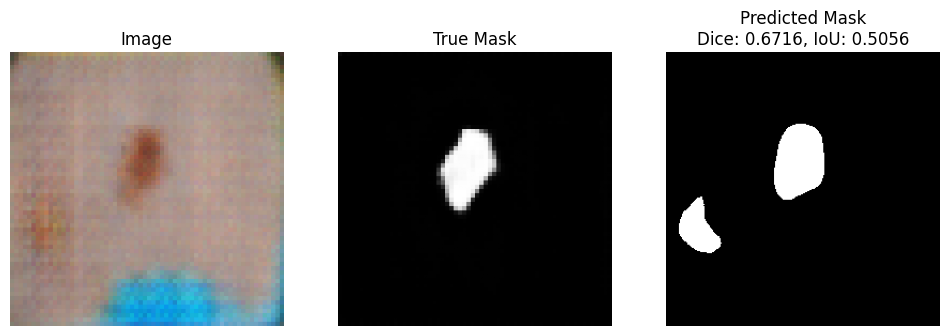

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


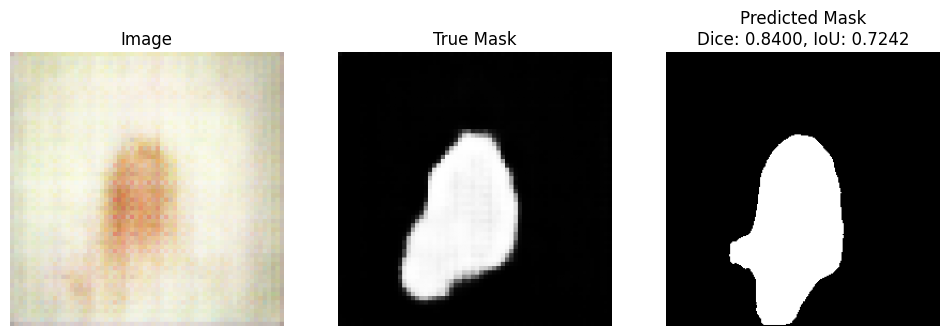

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


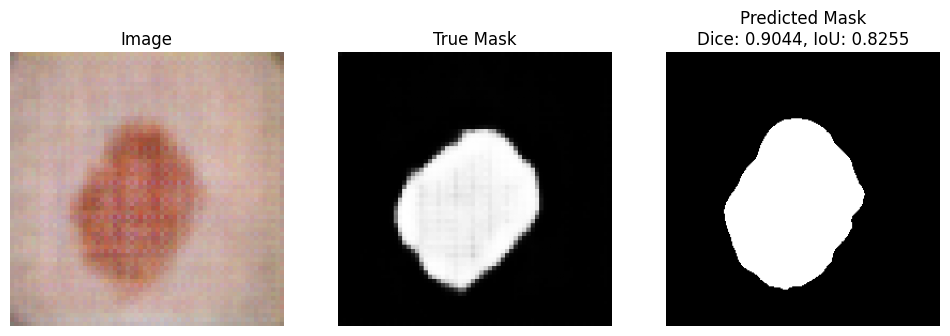

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


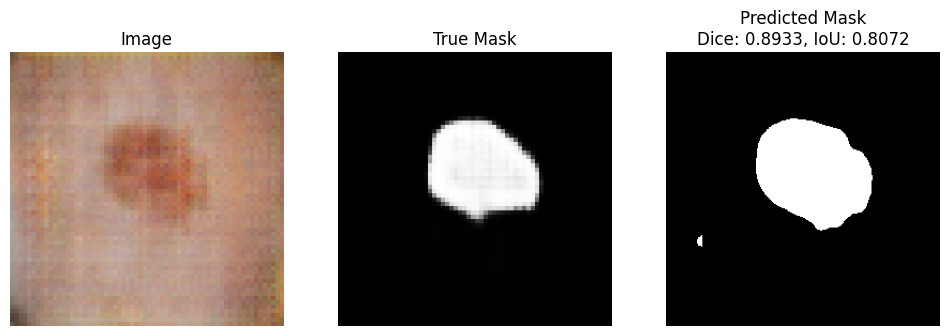

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


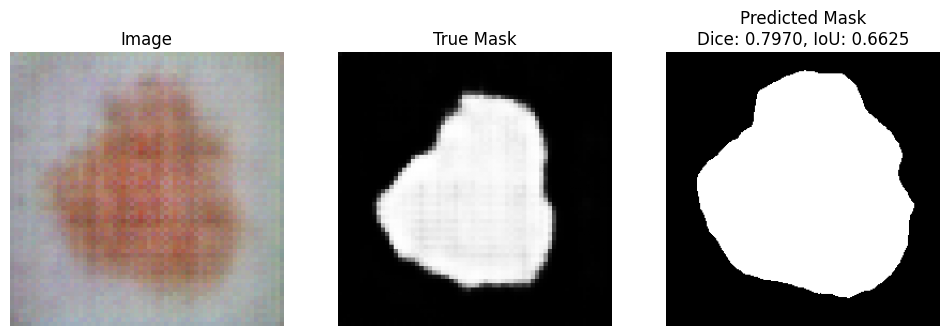

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf  # Ensure TensorFlow is imported


# Function to load and preprocess test images and masks
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and preprocess the image and mask
        image = img_to_array(load_img(img_path, target_size=target_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode="grayscale")) / 255.0

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Dice coefficient calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

# Intersection over Union (IoU) calculation
def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Display sample predictions
def display_sample_predictions(model, x_test, y_test, num_samples=5):
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    for i in indices:
        image = x_test[i]
        true_mask = y_test[i]
        pred_mask = model.predict(image[np.newaxis, ...])[0]

        # Threshold the prediction
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Calculate Dice and IoU
        dice_score = dice_coefficient(true_mask, pred_mask).numpy()
        iou_score = intersection_over_union(true_mask, pred_mask).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, 0], cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, 0], cmap="gray")
        plt.title(f"Predicted Mask\nDice: {dice_score:.4f}, IoU: {iou_score:.4f}")
        plt.axis("off")

        plt.show()

# Evaluate metrics on the test set
def evaluate_metrics_on_test_set(model, x_test, y_test):
    dice_scores = []
    iou_scores = []

    for i in range(len(x_test)):
        true_mask = y_test[i]
        pred_mask = model.predict(x_test[i][np.newaxis, ...])[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_scores.append(dice_coefficient(true_mask, pred_mask).numpy())
        iou_scores.append(intersection_over_union(true_mask, pred_mask).numpy())

    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/unet___model.h5"
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient})

# Directories for generated images and masks
image_dir = "/content/drive/MyDrive/generatedImage"
mask_dir = "/content/drive/MyDrive/generatedMask"

# Load the test images and masks
x_test, y_test = load_images_and_masks(image_dir, mask_dir)

# Display sample predictions
display_sample_predictions(model, x_test, y_test, num_samples=5)

# Evaluate and display metrics
evaluate_metrics_on_test_set(model, x_test, y_test)


**Choose the best images and masks (generated by DFCA-GAN) by saving only the best segmentation results based on a Dice coefficient threshold (> 0.90).**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import tensorflow as tf

# Function to load and preprocess test images and masks
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and preprocess the image and mask
        image = img_to_array(load_img(img_path, target_size=target_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode="grayscale")) / 255.0

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks), image_filenames

# Dice coefficient calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

# Intersection over Union (IoU) calculation
def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Function to save images and masks with Dice > 0.90
def save_best_predictions(model, x_test, y_test, image_filenames, save_image_dir, save_mask_dir, threshold=0.90):
    os.makedirs(save_image_dir, exist_ok=True)
    os.makedirs(save_mask_dir, exist_ok=True)

    for i, (image, true_mask, filename) in enumerate(zip(x_test, y_test, image_filenames)):
        pred_mask = model.predict(image[np.newaxis, ...])[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_score = dice_coefficient(true_mask, pred_mask).numpy()

        if dice_score > threshold:
            # Save image and mask
            img_to_save = array_to_img(image)
            mask_to_save = array_to_img(pred_mask)

            img_to_save.save(os.path.join(save_image_dir, filename))
            mask_to_save.save(os.path.join(save_mask_dir, filename))

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/unet___model.h5"
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient})

# Directories for generated images and masks
image_dir = "/content/drive/MyDrive/generatedImage"
mask_dir = "/content/drive/MyDrive/generatedMask"

# Directories for saving the best predictions
save_image_dir = "/content/drive/MyDrive/BestImage"
save_mask_dir = "/content/drive/MyDrive/BestMask"

# Load the test images, masks, and filenames
x_test, y_test, image_filenames = load_images_and_masks(image_dir, mask_dir)

# Save images and masks with Dice > 0.90
save_best_predictions(model, x_test, y_test, image_filenames, save_image_dir, save_mask_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

**We got 724 images and masks**

In [ ]:
import os

# Define the directory containing images
image_dir = '/content/drive/MyDrive/BestMask'

# Count the number of images in the directory
image_count = len([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])

image_count


724

**Evaluate the best images and masks with a pre-trained U-Net**



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


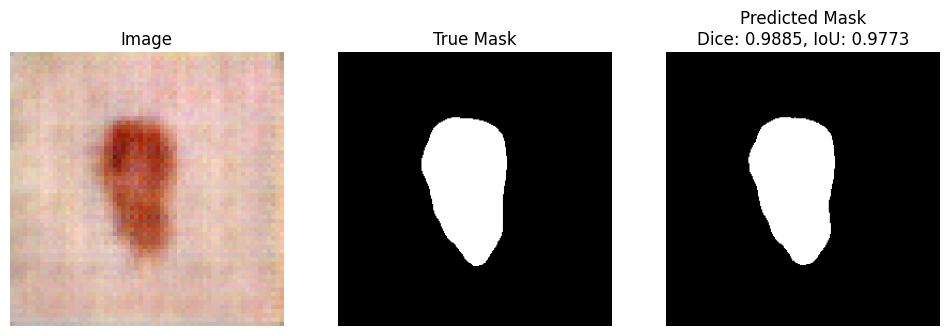

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


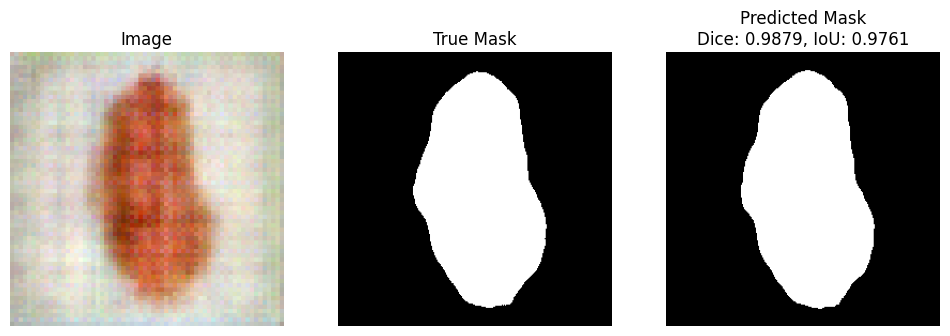

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


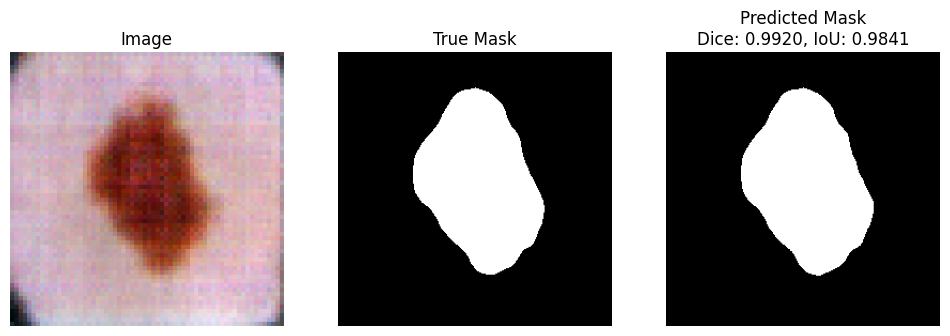

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


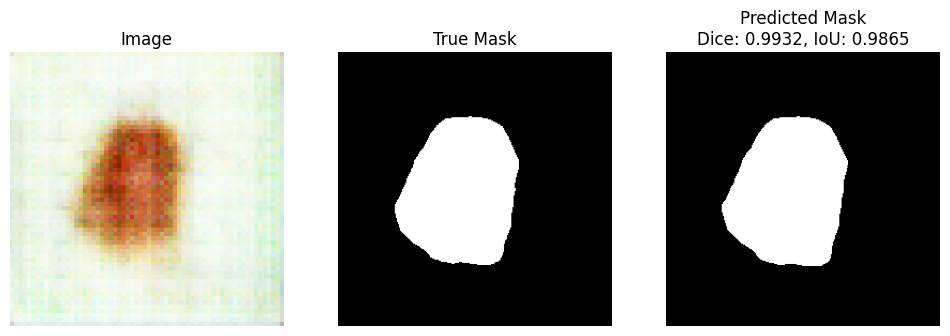

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


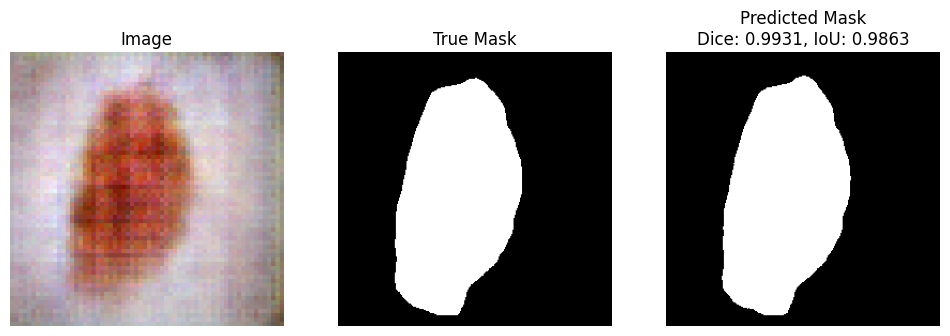

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf  # Ensure TensorFlow is imported


# Function to load and preprocess test images and masks
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and preprocess the image and mask
        image = img_to_array(load_img(img_path, target_size=target_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode="grayscale")) / 255.0

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Dice coefficient calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

# Intersection over Union (IoU) calculation
def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Display sample predictions
def display_sample_predictions(model, x_test, y_test, num_samples=5):
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    for i in indices:
        image = x_test[i]
        true_mask = y_test[i]
        pred_mask = model.predict(image[np.newaxis, ...])[0]

        # Threshold the prediction
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Calculate Dice and IoU
        dice_score = dice_coefficient(true_mask, pred_mask).numpy()
        iou_score = intersection_over_union(true_mask, pred_mask).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, 0], cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, 0], cmap="gray")
        plt.title(f"Predicted Mask\nDice: {dice_score:.4f}, IoU: {iou_score:.4f}")
        plt.axis("off")

        plt.show()

# Evaluate metrics on the test set
def evaluate_metrics_on_test_set(model, x_test, y_test):
    dice_scores = []
    iou_scores = []

    for i in range(len(x_test)):
        true_mask = y_test[i]
        pred_mask = model.predict(x_test[i][np.newaxis, ...])[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_scores.append(dice_coefficient(true_mask, pred_mask).numpy())
        iou_scores.append(intersection_over_union(true_mask, pred_mask).numpy())

    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/unet___model.h5"
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient})

# Directories for generated images and masks
image_dir = "/content/drive/MyDrive/BestImage"
mask_dir = "/content/drive/MyDrive/BestMask"

# Load the test images and masks
x_test, y_test = load_images_and_masks(image_dir, mask_dir)

# Display sample predictions
display_sample_predictions(model, x_test, y_test, num_samples=5)

# Evaluate and display metrics
evaluate_metrics_on_test_set(model, x_test, y_test)


**U-NET trained with ISIC 2016** (900 train 379 test)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.7241 - loss: 0.6063 - val_accuracy: 0.7195 - val_loss: 0.4933
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 90s 936ms/step - accuracy: 0.7800 - loss: 0.4565 - val_accuracy: 0.8315 - val_loss: 0.4050
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 78s 859ms/step - accuracy: 0.8368 - loss: 0.4093 - val_accuracy: 0.8145 - val_loss: 0.4467
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 87s 943ms/step - accuracy: 0.8291 - loss: 0.4147 - val_accuracy: 0.8433 - val_loss: 0.3907
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 77s 858ms/step - accuracy: 0.8407 - loss: 0.3940 - val_accuracy: 0.8409 - val_loss: 0.3884
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 959ms/step - accuracy: 0.8535 - loss: 0.3693 - val_accuracy: 0.8746 - val_loss: 0.3125
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 983ms/step - accuracy: 0.8825 - loss: 0.3086 - val_accuracy: 0.8846 - val_loss: 0.3083
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 77s 903ms/step - accuracy: 0.8992 - loss: 0.2694 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


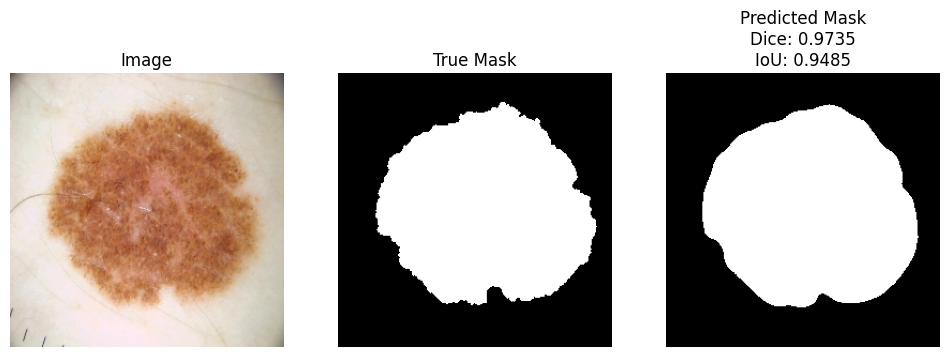

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


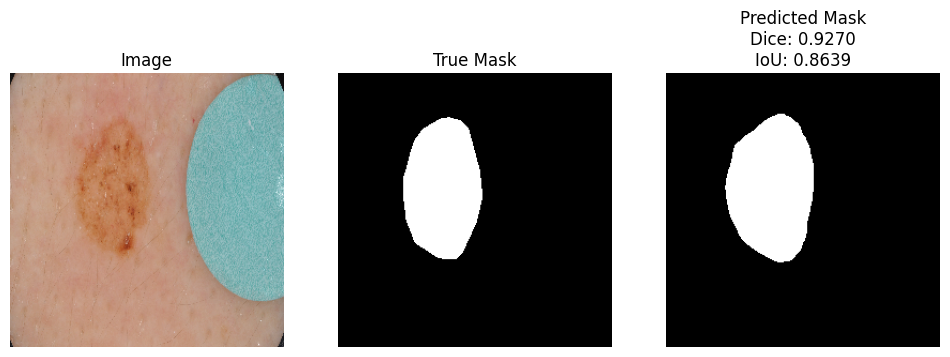

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


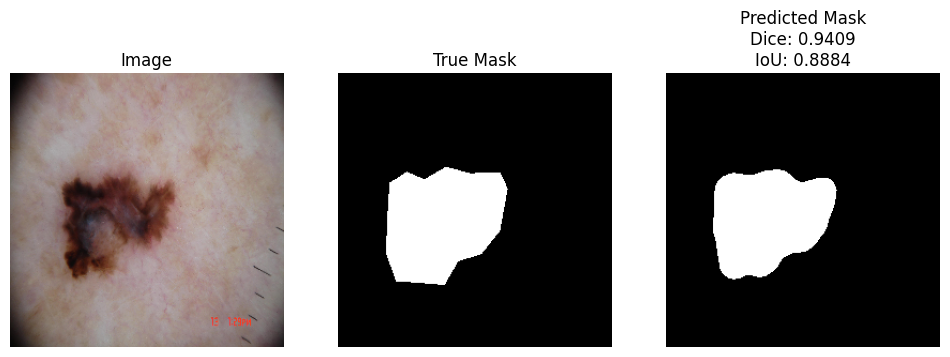

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


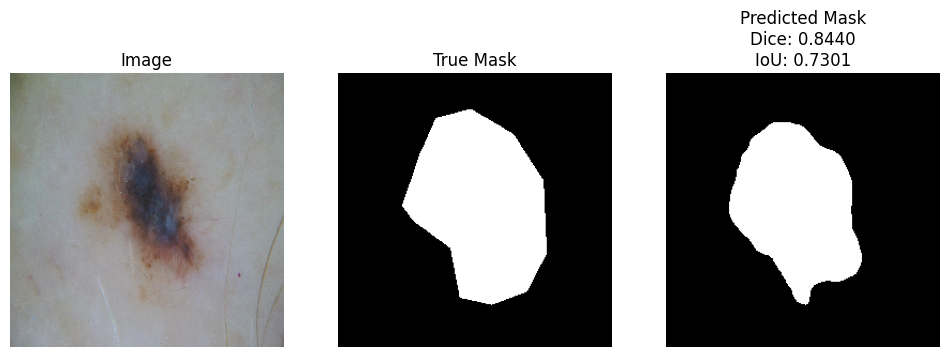

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


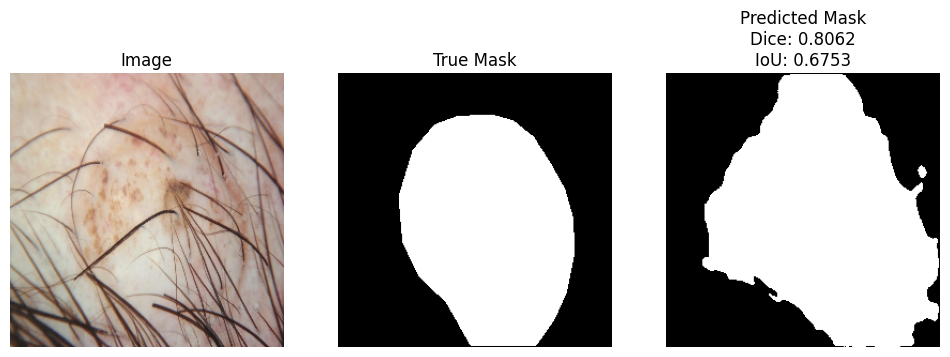

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt

# U-Net model definition
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Function to load and preprocess images and masks
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = img_to_array(load_img(img_path, target_size=target_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode="grayscale")) / 255.0

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Dice coefficient calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

# Intersection over Union (IoU) Calculation
def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Display sample predictions
def display_sample_predictions(model, x_test, y_test, num_samples=5):
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    for i in indices:
        image = x_test[i]
        true_mask = y_test[i]
        pred_mask = model.predict(image[np.newaxis, ...])[0]

        # Threshold the prediction
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_score = dice_coefficient(true_mask, pred_mask).numpy()
        iou_score = intersection_over_union(true_mask, pred_mask).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, 0], cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, 0], cmap="gray")
        plt.title(f"Predicted Mask\nDice: {dice_score:.4f}\nIoU: {iou_score:.4f}")
        plt.axis("off")

        plt.show()

# Calculate Dice coefficient and IoU for the entire test set
def evaluate_metrics_on_test_set(model, x_test, y_test):
    dice_scores = []
    iou_scores = []
    for i in range(len(x_test)):
        true_mask = y_test[i]
        pred_mask = model.predict(x_test[i][np.newaxis, ...])[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_scores.append(dice_coefficient(true_mask, pred_mask).numpy())
        iou_scores.append(intersection_over_union(true_mask, pred_mask).numpy())

    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    print(f"Mean Dice Coefficient on Test Set: {mean_dice:.4f}")
    print(f"Mean IoU on Test Set: {mean_iou:.4f}")

# Load the training and testing data
train_image_dir = "/content/drive/MyDrive/ISIC 2016/train"
train_mask_dir = "/content/drive/MyDrive/ISIC 2016/train_masks"
test_image_dir = "/content/drive/MyDrive/ISIC 2016/test"
test_mask_dir = "/content/drive/MyDrive/ISIC 2016/test_masks"

x_train, y_train = load_images_and_masks(train_image_dir, train_mask_dir)
x_test, y_test = load_images_and_masks(test_image_dir, test_mask_dir)

# Build and compile the U-Net model
input_size = (256, 256, 3)
model = unet_model(input_size=input_size)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=16
)

# Save the trained model
model.save("/content/drive/MyDrive/unet_model.h5")

# Display some predictions and Dice scores
display_sample_predictions(model, x_test, y_test, num_samples=5)

# Evaluate and display Dice and IoU on the test set
evaluate_metrics_on_test_set(model, x_test, y_test)


**DFCA-U-NET trained with ISIC 2016** (900 train 379 test)



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


57/57 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.6541 - loss: 0.6589 - val_accuracy: 0.7182 - val_loss: 0.5446
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 958ms/step - accuracy: 0.7383 - loss: 0.5090 - val_accuracy: 0.8327 - val_loss: 0.4571
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 946ms/step - accuracy: 0.8362 - loss: 0.4333 - val_accuracy: 0.8882 - val_loss: 0.3197
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 954ms/step - accuracy: 0.8673 - loss: 0.3488 - val_accuracy: 0.8822 - val_loss: 0.3139
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 957ms/step - accuracy: 0.8858 - loss: 0.3065 - val_accuracy: 0.8967 - val_loss: 0.2744
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 897ms/step - accuracy: 0.8926 - loss: 0.2888 - val_accuracy: 0.9090 - val_loss: 0.2548
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 954ms/step - accuracy: 0.9062 - loss: 0.2678 - val_accuracy: 0.9099 - val_loss: 0.2413
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 955ms/step - accuracy: 0.9095 - loss: 0.2514 - val_accuracy: 0.9038 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


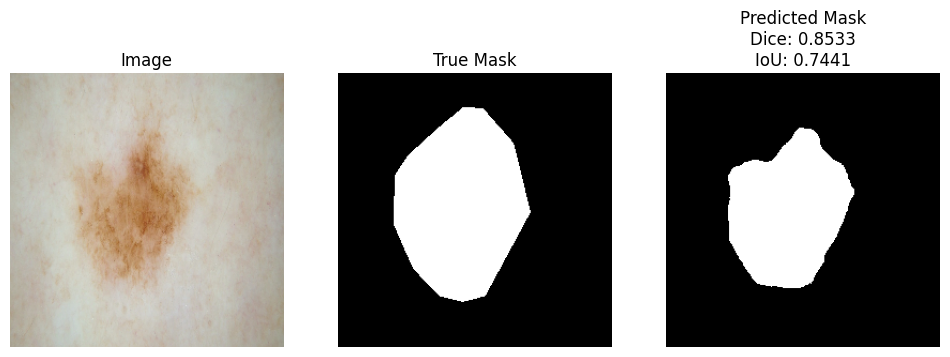

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


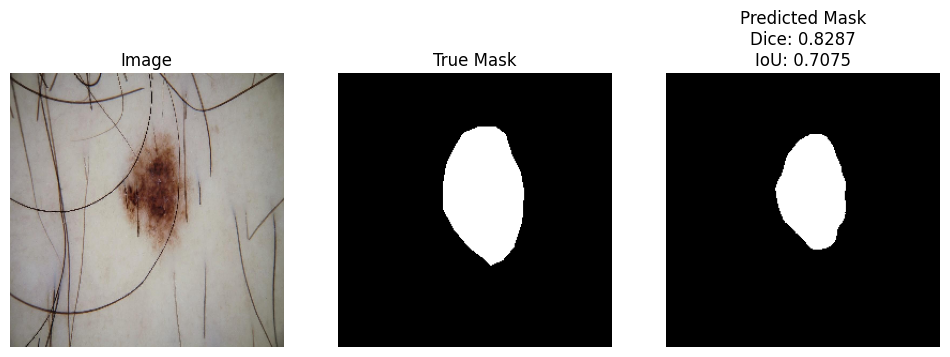

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


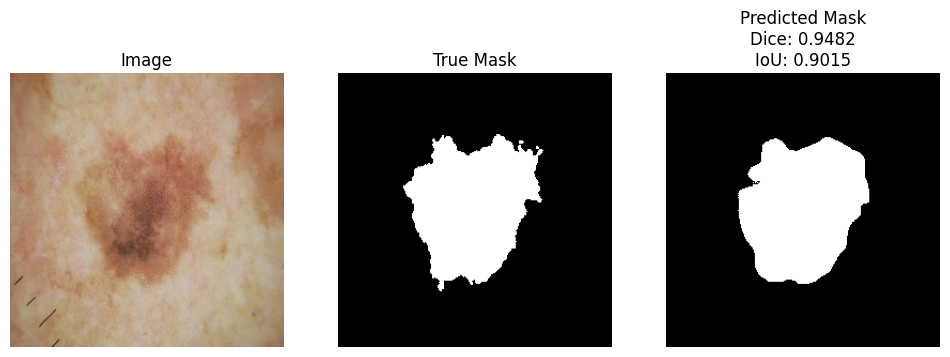

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


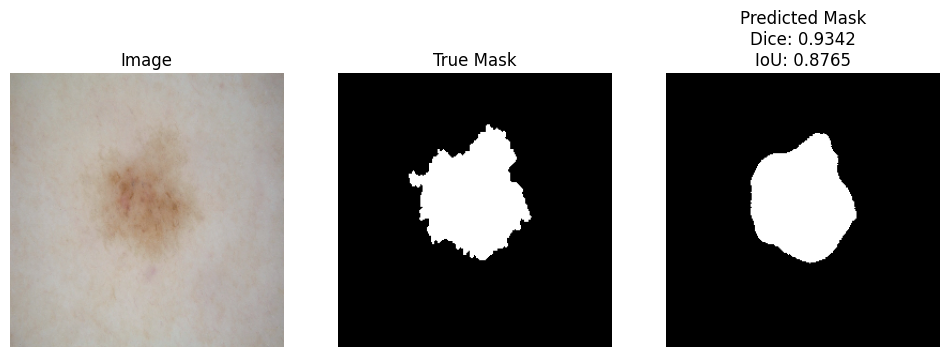

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


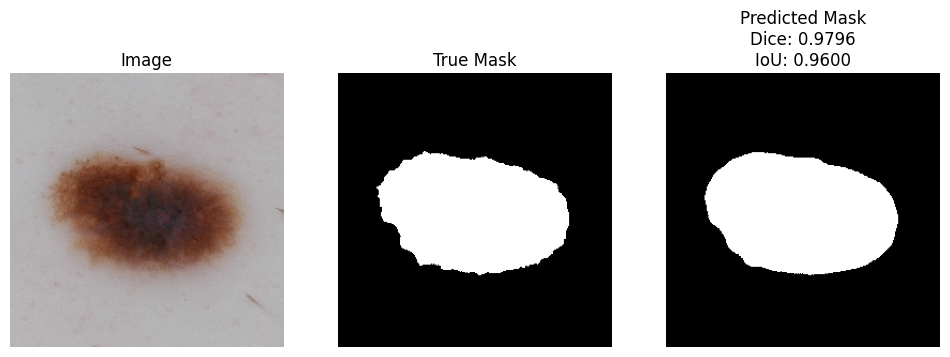

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt

# U-Net model definition
# DFCA Layer (Dynamic Feature Contextual Activation)
class DFCA(layers.Layer):
    def __init__(self, channels):
        super(DFCA, self).__init__()
        self.channels = channels
        self.fc = models.Sequential([
            layers.Flatten(),
            layers.Dense(channels // 2, activation='relu'),
            layers.Dense(channels, activation='sigmoid')
        ])

    def call(self, inputs):
        batch_size, height, width, channels = inputs.shape
        context = tf.reduce_mean(inputs, axis=(1, 2))  # Global Context: Mean across spatial dimensions
        context = self.fc(context)  # Fully connected layer to get scaling factor for channels
        context = tf.reshape(context, (-1, 1, 1, channels))  # Reshape to match input dimensions
        return inputs * context  # Apply feature scaling using context

# U-Net model definition with DFCA
def unet_model_with_dfca(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = DFCA(64)(c1)  # Apply DFCA after the first convolution
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = DFCA(128)(c2)  # Apply DFCA after the second convolution
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = DFCA(256)(c3)  # Apply DFCA after the third convolution
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = DFCA(512)(c4)  # Apply DFCA after the fourth convolution
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = DFCA(512)(c6)  # Apply DFCA after the sixth convolution

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = DFCA(256)(c7)  # Apply DFCA after the seventh convolution

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = DFCA(128)(c8)  # Apply DFCA after the eighth convolution

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = DFCA(64)(c9)  # Apply DFCA after the ninth convolution

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Function to load and preprocess images and masks
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and normalize images
        image = img_to_array(load_img(img_path, target_size=target_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode="grayscale")) / 255.0

        images.append(image)
        masks.append(mask)

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    # Ensure masks have the correct shape (num_samples, 256, 256, 1)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks

# Dice coefficient calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

# Intersection over Union (IoU) Calculation
def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Display sample predictions
def display_sample_predictions(model, x_test, y_test, num_samples=5):
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    for i in indices:
        image = x_test[i]
        true_mask = y_test[i]
        pred_mask = model.predict(image[np.newaxis, ...])[0]

        # Threshold the prediction
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_score = dice_coefficient(true_mask, pred_mask).numpy()
        iou_score = intersection_over_union(true_mask, pred_mask).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, 0], cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, 0], cmap="gray")
        plt.title(f"Predicted Mask\nDice: {dice_score:.4f}\nIoU: {iou_score:.4f}")
        plt.axis("off")

        plt.show()

# Calculate Dice coefficient and IoU for the entire test set
def evaluate_metrics_on_test_set(model, x_test, y_test):
    dice_scores = []
    iou_scores = []
    for i in range(len(x_test)):
        true_mask = y_test[i]
        pred_mask = model.predict(x_test[i][np.newaxis, ...])[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_scores.append(dice_coefficient(true_mask, pred_mask).numpy())
        iou_scores.append(intersection_over_union(true_mask, pred_mask).numpy())

    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    print(f"Mean Dice Coefficient on Test Set: {mean_dice:.4f}")
    print(f"Mean IoU on Test Set: {mean_iou:.4f}")

# Load the training and testing data
train_image_dir = "/content/drive/MyDrive/ISIC 2016/train"
train_mask_dir = "/content/drive/MyDrive/ISIC 2016/train_masks"
test_image_dir = "/content/drive/MyDrive/ISIC 2016/test"
test_mask_dir = "/content/drive/MyDrive/ISIC 2016/test_masks"

x_train, y_train = load_images_and_masks(train_image_dir, train_mask_dir)
x_test, y_test = load_images_and_masks(test_image_dir, test_mask_dir)

# Build and compile the U-Net model
input_size = (256, 256, 3)
model = unet_model_with_dfca(input_size=input_size)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=16
)

# Save the trained model
model.save("/content/drive/MyDrive/unet_model_last.h5")

# Display some predictions and Dice scores
display_sample_predictions(model, x_test, y_test, num_samples=5)

# Evaluate and display Dice and IoU on the test set
evaluate_metrics_on_test_set(model, x_test, y_test)


In [ ]:
# Get final loss and accuracy
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Loss: 0.0791
Final Validation Loss: 0.1380
Final Training Accuracy: 0.9665
Final Validation Accuracy: 0.9499


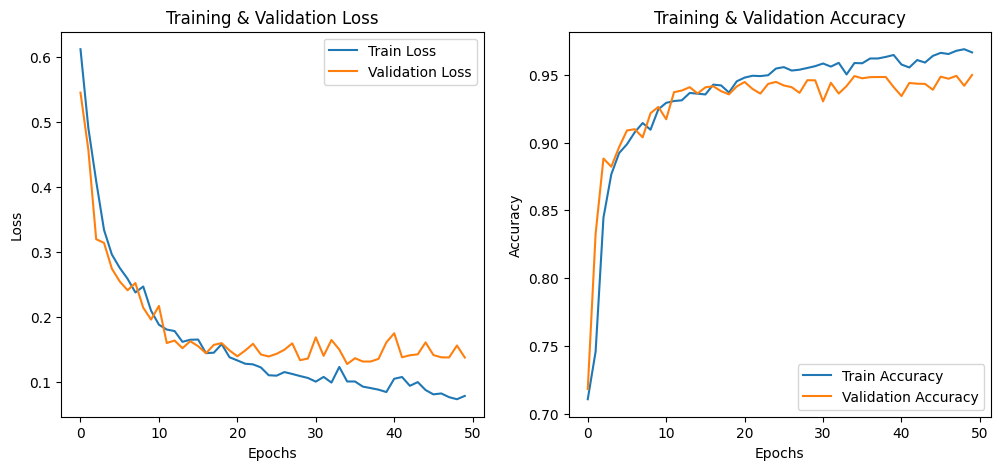

In [ ]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


**DFCA-U-NET trained with ISIC 2016 + augmented images (724)** (1624 train 379 test)

In [ ]:
import os

# Define the directory containing images
image_dir = '/content/drive/MyDrive/BestMask'

# Count the number of images in the directory
image_count = len([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])

image_count


1624

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


102/102 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.6724 - loss: 0.6196 - val_accuracy: 0.8314 - val_loss: 0.4012
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 134s 854ms/step - accuracy: 0.8801 - loss: 0.3299 - val_accuracy: 0.8817 - val_loss: 0.3015
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 145s 886ms/step - accuracy: 0.9057 - loss: 0.2583 - val_accuracy: 0.8959 - val_loss: 0.2768
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 885ms/step - accuracy: 0.9258 - loss: 0.2179 - val_accuracy: 0.8954 - val_loss: 0.2845
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 885ms/step - accuracy: 0.9250 - loss: 0.2098 - val_accuracy: 0.9001 - val_loss: 0.2814
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 884ms/step - accuracy: 0.9317 - loss: 0.1906 - val_accuracy: 0.9197 - val_loss: 0.2203
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 886ms/step - accuracy: 0.9396 - loss: 0.1613 - val_accuracy: 0.9190 - val_loss: 0.2119
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 886ms/step - accuracy: 0.9439 - loss: 0.1500 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


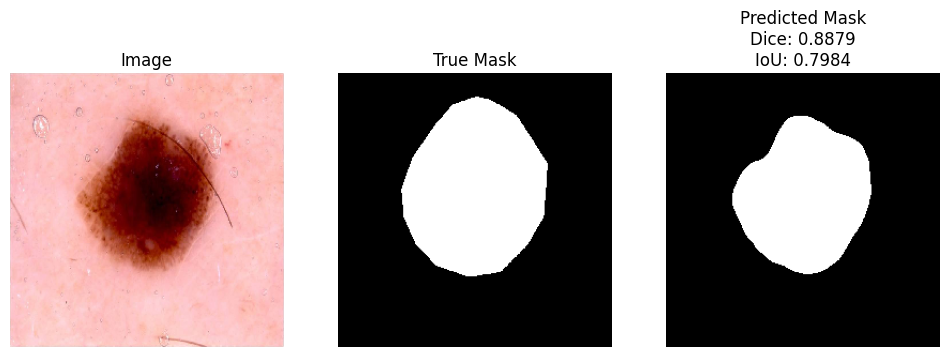

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


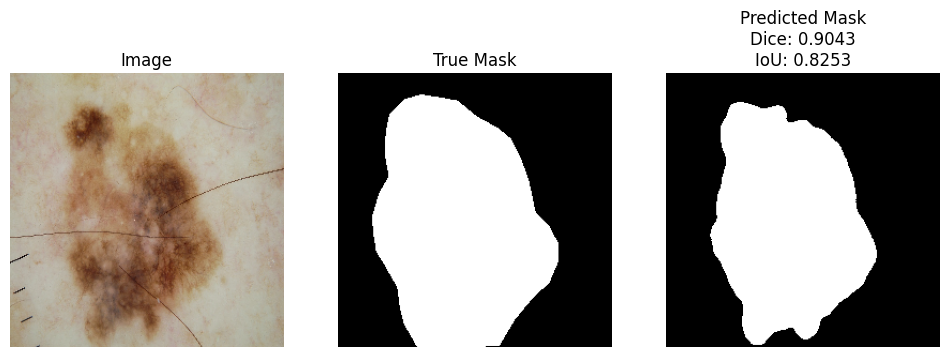

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


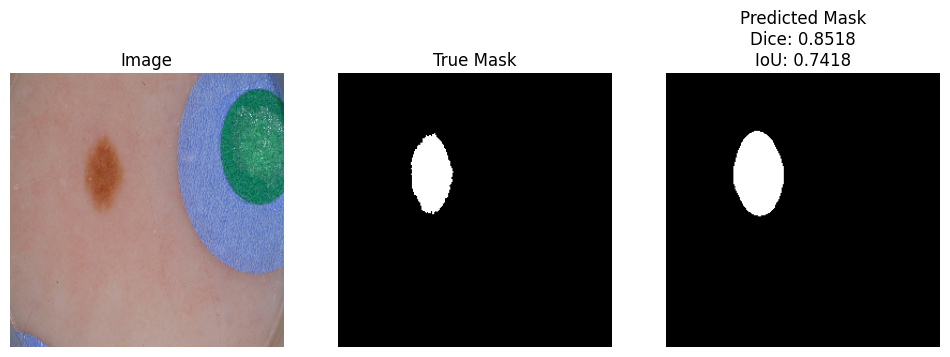

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


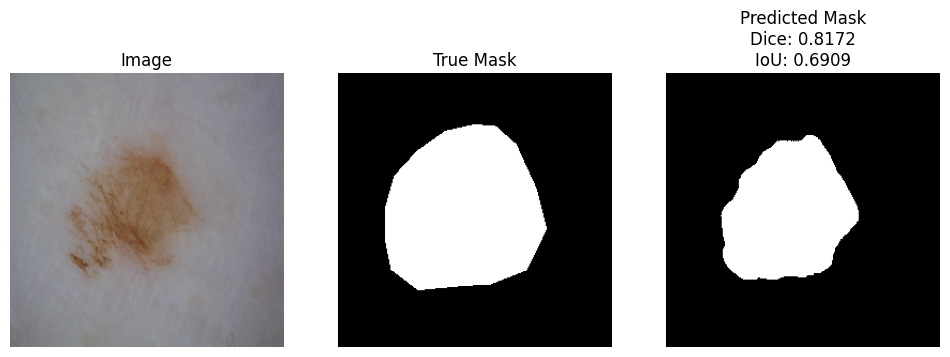

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


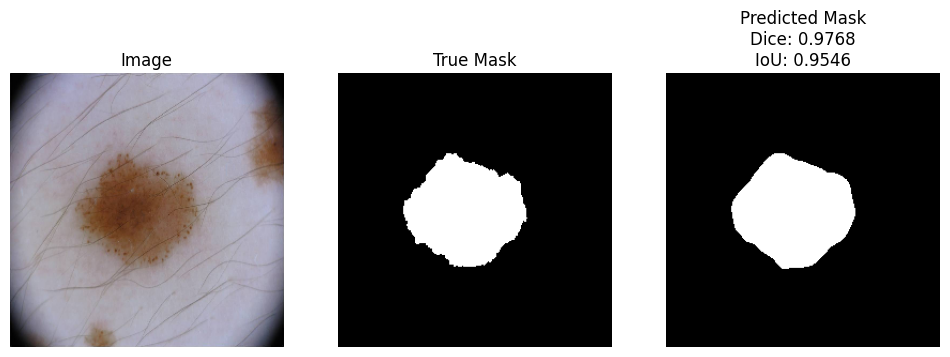

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt

# U-Net model definition
# DFCA Layer (Dynamic Feature Contextual Activation)
class DFCA(layers.Layer):
    def __init__(self, channels):
        super(DFCA, self).__init__()
        self.channels = channels
        self.fc = models.Sequential([
            layers.Flatten(),
            layers.Dense(channels // 2, activation='relu'),
            layers.Dense(channels, activation='sigmoid')
        ])

    def call(self, inputs):
        batch_size, height, width, channels = inputs.shape
        context = tf.reduce_mean(inputs, axis=(1, 2))  # Global Context: Mean across spatial dimensions
        context = self.fc(context)  # Fully connected layer to get scaling factor for channels
        context = tf.reshape(context, (-1, 1, 1, channels))  # Reshape to match input dimensions
        return inputs * context  # Apply feature scaling using context

# U-Net model definition with DFCA
def unet_model_with_dfca(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = DFCA(64)(c1)  # Apply DFCA after the first convolution
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = DFCA(128)(c2)  # Apply DFCA after the second convolution
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = DFCA(256)(c3)  # Apply DFCA after the third convolution
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = DFCA(512)(c4)  # Apply DFCA after the fourth convolution
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = DFCA(512)(c6)  # Apply DFCA after the sixth convolution

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = DFCA(256)(c7)  # Apply DFCA after the seventh convolution

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = DFCA(128)(c8)  # Apply DFCA after the eighth convolution

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = DFCA(64)(c9)  # Apply DFCA after the ninth convolution

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Function to load and preprocess images and masks
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and normalize images
        image = img_to_array(load_img(img_path, target_size=target_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode="grayscale")) / 255.0

        images.append(image)
        masks.append(mask)

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    # Ensure masks have the correct shape (num_samples, 256, 256, 1)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks

# Dice coefficient calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

# Intersection over Union (IoU) Calculation
def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Display sample predictions
def display_sample_predictions(model, x_test, y_test, num_samples=5):
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    for i in indices:
        image = x_test[i]
        true_mask = y_test[i]
        pred_mask = model.predict(image[np.newaxis, ...])[0]

        # Threshold the prediction
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_score = dice_coefficient(true_mask, pred_mask).numpy()
        iou_score = intersection_over_union(true_mask, pred_mask).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, 0], cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, 0], cmap="gray")
        plt.title(f"Predicted Mask\nDice: {dice_score:.4f}\nIoU: {iou_score:.4f}")
        plt.axis("off")

        plt.show()

# Calculate Dice coefficient and IoU for the entire test set
def evaluate_metrics_on_test_set(model, x_test, y_test):
    dice_scores = []
    iou_scores = []
    for i in range(len(x_test)):
        true_mask = y_test[i]
        pred_mask = model.predict(x_test[i][np.newaxis, ...])[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_scores.append(dice_coefficient(true_mask, pred_mask).numpy())
        iou_scores.append(intersection_over_union(true_mask, pred_mask).numpy())

    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    print(f"Mean Dice Coefficient on Test Set: {mean_dice:.4f}")
    print(f"Mean IoU on Test Set: {mean_iou:.4f}")

# Load the training and testing data
train_image_dir = "/content/drive/MyDrive/BestImage"
train_mask_dir = "/content/drive/MyDrive/BestMask"
test_image_dir = "/content/drive/MyDrive/ISIC 2016/test"
test_mask_dir = "/content/drive/MyDrive/ISIC 2016/test_masks"

x_train, y_train = load_images_and_masks(train_image_dir, train_mask_dir)
x_test, y_test = load_images_and_masks(test_image_dir, test_mask_dir)

# Build and compile the U-Net model
input_size = (256, 256, 3)
model = unet_model_with_dfca(input_size=input_size)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=16
)

# Save the trained model
model.save("/content/drive/MyDrive/unet_model_DFCA_22_best2.h5")

# Display some predictions and Dice scores
display_sample_predictions(model, x_test, y_test, num_samples=5)

# Evaluate and display Dice and IoU on the test set
evaluate_metrics_on_test_set(model, x_test, y_test)


In [ ]:
# Get final loss and accuracy
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Loss: 0.0395
Final Validation Loss: 0.1669
Final Training Accuracy: 0.9834
Final Validation Accuracy: 0.9513


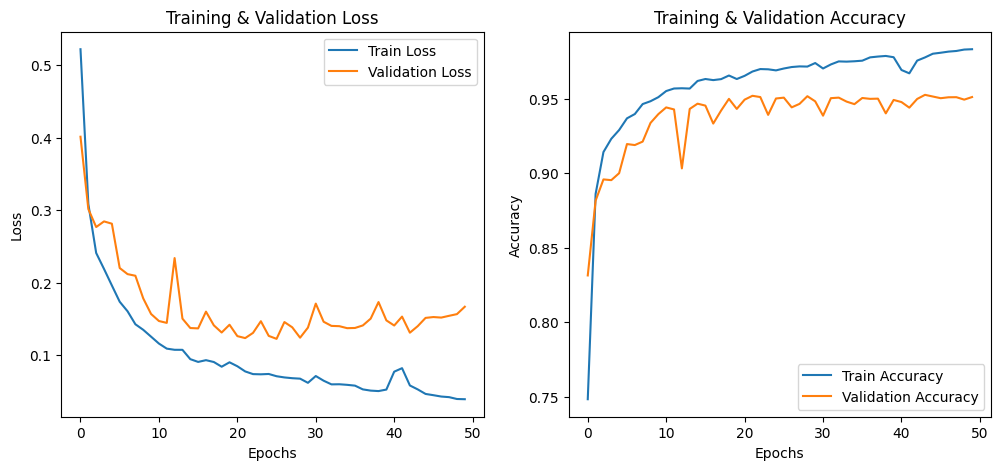

In [ ]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()
